# Perceptron Multicamadas, MNIST
---
Neste notebook, há um treinamento de um MLP para classificar imagems do [Banco de dados MNIST](http://yann.lecun.com/exdb/mnist/) de dígitos manuais em uma máquina virtual Oracle (VM.Standard.A1.Flex) com processador 2.8GHz Ampere Altra 80C, 18GB de memória e 3 OGPUS, no tier sempre grátis, com a imagem PyTorch 1.11.0 - Ampere® Optimized Framework - Ubuntu 20.04 fornecida pela	Ampere Computing LLC.

O processo é dividido nos seguintes passos:
1. Carregar e visualizar os dados
2. Definir uma rede neural
3. Treinar o modelo
4. Avaliar a performance do nosso modelo num dataset de testes!

In [13]:
# importar bibliotecas e definir paralelismo
import torch
import numpy as np
#torch.set_num_interop_threads(3) # Inter-op parallelism

---
##  Carregar e visualizar os [dados](http://pytorch.org/docs/stable/torchvision/datasets.html)



In [14]:
# Os dadasets do MNIST datasets estão hosteados no endereço yann.lecun.com 
# que está sob proteção da CloudFlare
# Este script possibilita o download dos datasets
# https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [15]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# número de subprocessos para se utilizar para carregar os dados
num_subprocessos = 0
# quantas amostras por lotes para carregar
tamanho_lote = 20
# porcentagem do conjunto de treino para se utilizar como validação
tamanho_valido = 0.2

# converter os dados para torch.FloatTensor
transformar = transforms.ToTensor()

# escolher os datasets de treino e teste
dados_treino = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transformar)
dados_teste = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transformar)

#obter índices de treino que serão utilizados para validação
num_treino = len(dados_treino)
indices = list(range(num_treino))
np.random.shuffle(indices)
dividir = int(np.floor(tamanho_valido * num_treino))
train_idx, valid_idx = indices[dividir:], indices[:dividir]

# definir amostras para obter lotes de treino e validação
amostra_treino = SubsetRandomSampler(train_idx)
amostra_validacao = SubsetRandomSampler(valid_idx)

# preparar carregador de dados
carregador_treino = torch.utils.data.DataLoader(dados_treino, batch_size=tamanho_lote,
    sampler=amostra_treino, num_workers=num_subprocessos)
carregador_validacao = torch.utils.data.DataLoader(dados_treino, batch_size=tamanho_lote, 
    sampler=amostra_validacao, num_workers=num_subprocessos)
carregador_teste = torch.utils.data.DataLoader(dados_teste, batch_size=tamanho_lote, 
    num_workers=num_subprocessos)

### Visualizar um lote de dados de treino

Tarefa de classificação para olhar para os dados, assegurar-se que eles foram carregados corretamente, e fazer observações iniciais sobre padrões nestes dados

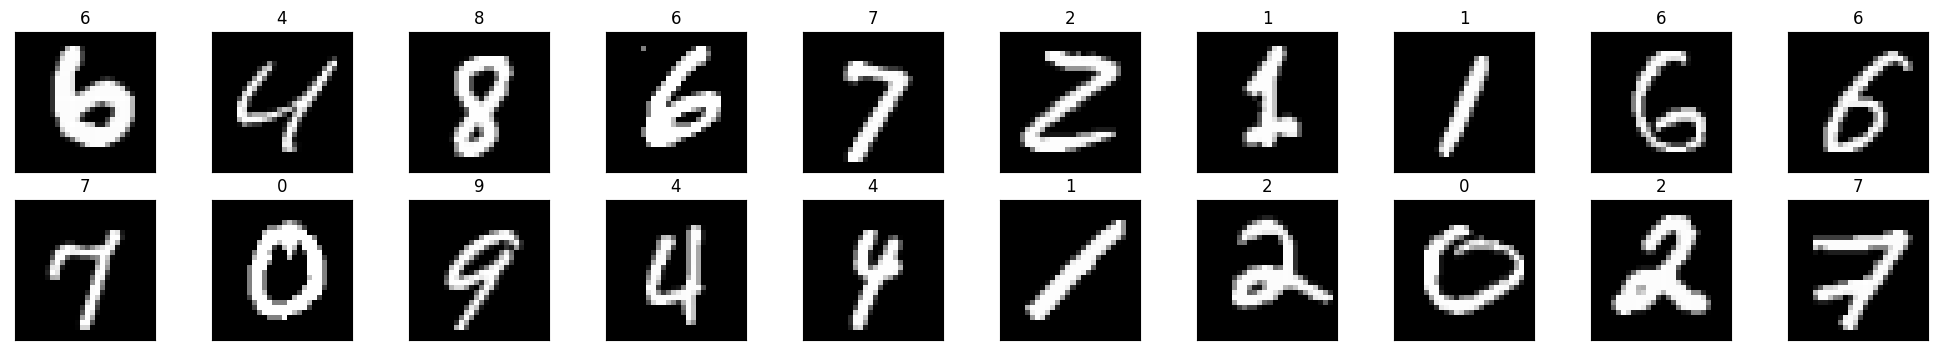

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obter um lote de imagens de treino
dataiter = iter(carregador_treino)
imagens, rotulos = dataiter.next()
imagens = imagens.numpy()

# plotar as imagems no lote, junto com os rótulos correspondentes
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(imagens[idx]), cmap='gray')
    # imprimir o rótulo correto para cada imagem
    # .item() consegue o valor contido em um Tensor
    ax.set_title(str(rotulos[idx].item()))

### Ver uma imagem com mais detalhes

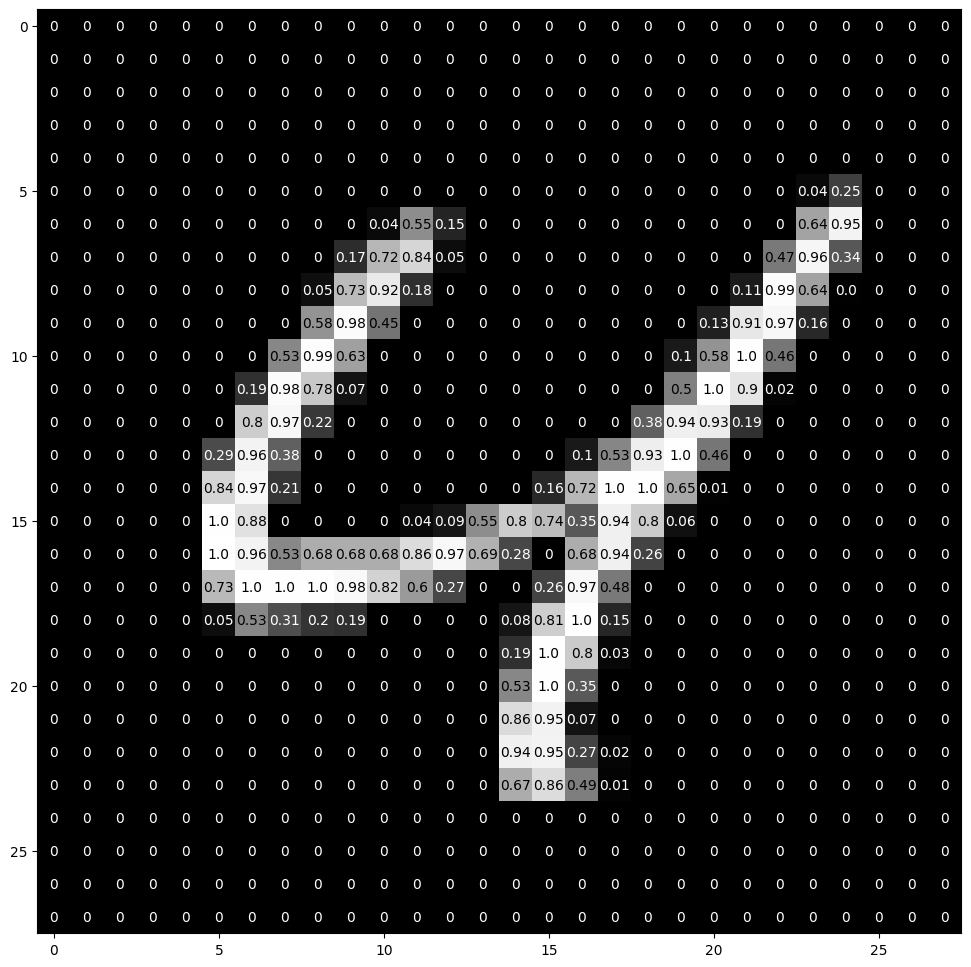

In [17]:
img = np.squeeze(imagens[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
largura, altura = img.shape
limite = img.max()/2.5
for x in range(largura):
    for y in range(altura):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<limite else 'black')

---
## Definir a [arquitetura](http://pytorch.org/docs/stable/nn.html) de rede 

A arquitetura será responsável por ver como entrada um Tensor de 784 dimensões de valores de píxel para cada imagem, e produzir um Tensor de tamanho 10 (número de classes) que indica os valores de classe para uma imagem de entrada. Este exemplo usa 2 camadas e dropout para evitar overfitting.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# definir a arquitetura NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # número de nodos escondidos em cada camada (512)
        escondida_1 = 512
        escondida_2 = 512
        # camada linear (784 -> escondida_1)
        self.fc1 = nn.Linear(28 * 28, escondida_1)
        # camada linear (n_escondida -> escondida_2)
        self.fc2 = nn.Linear(escondida_1, escondida_2)
        # camada linear (n_escondida -> 10)
        self.fc3 = nn.Linear(escondida_2, 10)
        # camada de dropout (p=0.2)
        # dropout  previne overfitting
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # achatar entrada de imagem
        x = x.view(-1, 28 * 28)
        # adicionar camada escondida, com função de ativação relu
        x = F.relu(self.fc1(x))
        # adicionar camada de dropout
        x = self.dropout(x)
        # adicionar camada escondida, com função de ativação relu
        x = F.relu(self.fc2(x))
        # adicionar camada de dropout
        x = self.dropout(x)
        # add saida layer
        x = self.fc3(x)
        return x

# inicializar a rede neural
modelo = Net()
print(modelo)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Especificar a [função de perda](http://pytorch.org/docs/stable/nn.html#loss-functions) e o [Otimizador](http://pytorch.org/docs/stable/optim.html)

Utiliza-se cross-entropia para classificação. A função de cross-entropia do pytorch aplica uma função softmax para a camada de saida e calcula a perda logarítmica.

In [19]:
# especificar a função de perda
criterio = nn.CrossEntropyLoss()

# especificar otimizador
otimizador = torch.optim.SGD(modelo.parameters(), lr=0.01)

---
## Treinar a rede

1. Limpar os gradientes de todas as variáveis otimizadas
2. Passo a frente: computar as saídas previstas ao passar entradas para o modelo
3. Calcular a perda
4. Passo a traz: computar o gradiente de perda com respeito a parâmetros modelos
5. Executar um único passo de otimização (atualização de parâmetro)
6. Atualizar a média de perda no treino

In [20]:
# número de epocas para treinar o modelo
n_epocas = 50

# inicializa o rastreador para perda de validação mínima
minimo_inicial_validacao = np.Inf # coloca o mínimo inicial para infinito

for epoca in range(n_epocas):
    # monitora perda de treino
    perda_treino = 0.0
    perda_validacao = 0.0
    
    ###################
    # treinar o modelo #
    ###################
    modelo.train() # preparar modelo para treinar
    for data, alvo in carregador_treino:
        # limpar os gradientes de todas variáveus otimizadas
        otimizador.zero_grad()
        # passo para frente: computar saídas previstas passando entradas para o modelo
        saida = modelo(data)
        # calcular a perda
        perda = criterio(saida, alvo)
        # passo para tras: computar o gradiente de perda com respeito a parâmetros modelo
        perda.backward()
        # executar um único passo de otimização (atualização de parâmetro)
        otimizador.step()
        # atualizar a perda de treino atual
        perda_treino += perda.item()
        
    ######################    
    # validar o modelo #
    ######################
    modelo.eval() # prepar modelo para avaliação
    for data, alvo in carregador_validacao:
        # passo para frente: computar saídas previstas passando entradas para o modelo
        saida = modelo(data)
       # calcular a perda
        perda = criterio(saida, alvo)
        # atualizar a perda de validação atual
        perda_validacao += perda.item()
        
    # imprimir as estatísticas de treino/validação 
    # calcular a perda média em uma época
    perda_treino = perda_treino/len(carregador_treino)
    perda_validacao = perda_validacao/len(carregador_validacao)
    
    print('Epoca: {} \tPerda de treino: {:.6f} \tPerda de validação: {:.6f}'.format(
        epoca+1, 
        perda_treino,
        perda_validacao
        ))
    
    # salvar modelo se a validaão diminuir
    if perda_validacao <= minimo_inicial_validacao:
        print('Perda de validação decaiu ({:.6f} --> {:.6f}).  Salvando modelo ...'.format(
        minimo_inicial_validacao,
        perda_validacao))
        torch.save(modelo.state_dict(), 'modelo.pt')
        minimo_inicial_validacao = perda_validacao

Epoca: 1 	Perda de treino: 0.962320 	Perda de validação: 0.386220
Perda de validação decaiu (inf --> 0.386220).  Salvando modelo ...
Epoca: 2 	Perda de treino: 0.361405 	Perda de validação: 0.290147
Perda de validação decaiu (0.386220 --> 0.290147).  Salvando modelo ...
Epoca: 3 	Perda de treino: 0.288275 	Perda de validação: 0.243264
Perda de validação decaiu (0.290147 --> 0.243264).  Salvando modelo ...
Epoca: 4 	Perda de treino: 0.238854 	Perda de validação: 0.204548
Perda de validação decaiu (0.243264 --> 0.204548).  Salvando modelo ...
Epoca: 5 	Perda de treino: 0.201563 	Perda de validação: 0.177903
Perda de validação decaiu (0.204548 --> 0.177903).  Salvando modelo ...
Epoca: 6 	Perda de treino: 0.174018 	Perda de validação: 0.159081
Perda de validação decaiu (0.177903 --> 0.159081).  Salvando modelo ...
Epoca: 7 	Perda de treino: 0.152849 	Perda de validação: 0.142461
Perda de validação decaiu (0.159081 --> 0.142461).  Salvando modelo ...
Epoca: 8 	Perda de treino: 0.136840 	Pe

In [21]:
modelo.load_state_dict(torch.load('modelo.pt'))

<All keys matched successfully>

---
## Testar a rede treinada

Testar o melhor modelo com dados não rodados no modelo e avaliar sua performance.
#### `modelo.eval()`

`modelo.eval(`) vai definir todas as camadas no modelo para modo de avaliação. Afeta camadas de dropout que desligam nodos durante o treino com alguma probabilidade, mas agora os deixam ligados para avaliação

In [22]:
# inicializar listas para monitorar perda de testes e acerto
perda_teste = 0.0
class_correto = list(0. for i in range(10))
class_total = list(0. for i in range(10))

modelo.eval() # preparar modelo para avaliação

for data, alvo in carregador_teste:
     # passo para frente: computar saídas previstas passando entradas para o modelo
    saida = modelo(data)
    # calculatar a perda
    perda = criterio(saida, alvo)
    # atualizar a perda de teste
    perda_teste += perda.item()*data.size(0)
    # converter probabilidadse de saida para classe prevista
    _, pred = torch.max(saida, 1)
    # comparar previsões com o verdadeiro rótulo
    correct = np.squeeze(pred.eq(alvo.data.view_as(pred)))
    # calcular a acurácia de teste para cada classe de objetos
    for i in range(tamanho_lote):
        label = alvo.data[i]
        class_correto[label] += correct[i].item()
        class_total[label] += 1

# calcular e imprimir a média de perda de testes
perda_teste = perda_teste/len(carregador_teste.dataset)
print('Perda de teste: {:.6f}\n'.format(perda_teste))

for i in range(10):
    if class_total[i] > 0:
        print('Acurácia de teste de %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correto[i] / class_total[i],
            np.sum(class_correto[i]), np.sum(class_total[i])))
    else:
        print('Acurácia de teste de %5s: N/A (sem exemplos de treino)' % (classes[i]))

print('\nAcurácia de teste (Geral): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correto) / np.sum(class_total),
    np.sum(class_correto), np.sum(class_total)))

Perda de teste: 0.060342

Acurácia de teste de     0: 99% (971/980)
Acurácia de teste de     1: 98% (1123/1135)
Acurácia de teste de     2: 98% (1014/1032)
Acurácia de teste de     3: 98% (994/1010)
Acurácia de teste de     4: 97% (962/982)
Acurácia de teste de     5: 97% (873/892)
Acurácia de teste de     6: 98% (940/958)
Acurácia de teste de     7: 97% (1003/1028)
Acurácia de teste de     8: 96% (943/974)
Acurácia de teste de     9: 97% (984/1009)

Acurácia de teste (Geral): 98% (9807/10000)


### Visualizar resultados de testes de amostra

verde para certo vermelho para errado

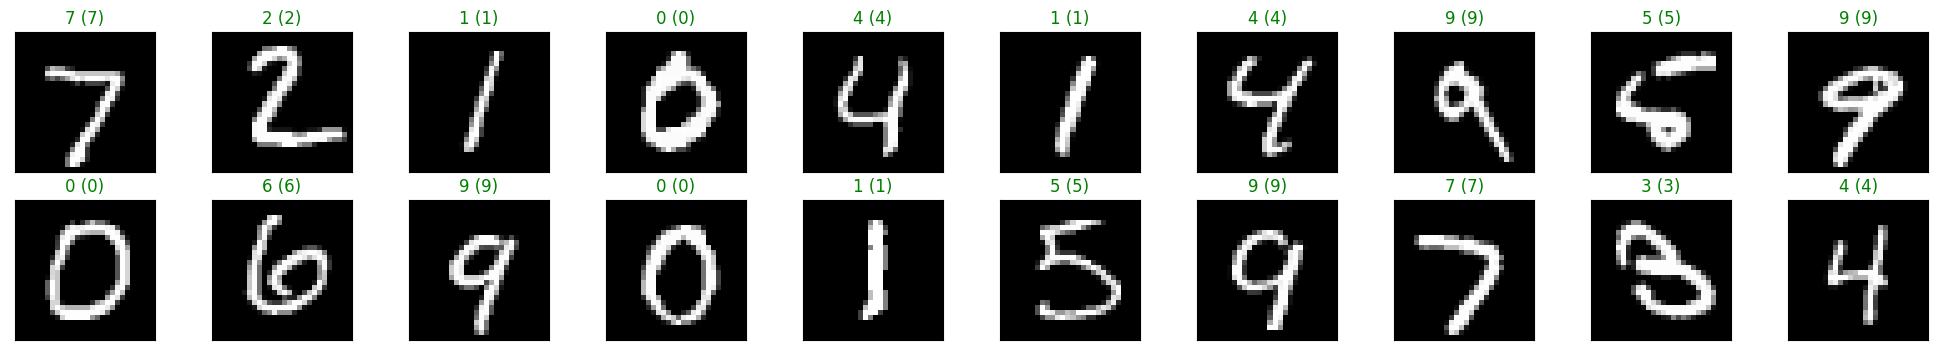

In [23]:
# obter um lote de imagens de teste
dataiter = iter(carregador_teste)
imagens, rotulos = dataiter.next()

# obter amostras de saida
saida = modelo(imagens)
# converter probabilidade de saidas para classe prevista
_, prevs = torch.max(saida, 1)
# preparar imagens para mostra
imagens = imagens.numpy()

# plotar as imagens no lote, junto com os rótulos previstos e verdadeiros
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(imagens[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(prevs[idx].item()), str(rotulos[idx].item())),
                 color=("green" if prevs[idx]==rotulos[idx] else "red"))